In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice

from torch import nn
from torch.nn import functional as F

import sys 
import getpass

sys.path.append('../Proj_308427_348143_XXXXXX')
from Miniproject_2.model import *
torch.set_grad_enabled(True);

In [2]:
train_in, train_tg = torch.load('../train_data.pkl')
train_in = train_in[:1000].float()/255.
train_tg = train_tg[:1000].float()/255.

val_in, val_tg = torch.load('../val_data.pkl')
val_in = val_in.float()/255.
val_tg = val_tg.float()/255.

bs = 16
ne = 20

In [3]:
def nn_init_weights(model):
    if isinstance(model,nn.Conv2d) or isinstance(model,nn.ConvTranspose2d):
        xavier_normal_(model.weight.data)

In [11]:
def train_nn(model, criterion, train_input, train_target, mini_batch_size, nb_epochs, eta=0.75, optimize=False):
    if optimize: optimizer = torch.optim.SGD(model.parameters(), lr=eta, )
    
    for e in range(nb_epochs):
        for inputs, targets in zip(train_input.split(mini_batch_size), train_target.split(mini_batch_size)):
            output = model(inputs)
            loss = criterion(output, targets)

            model.zero_grad()
            loss.backward()
            
            if optimize:
                optimizer.step()
            else:
                with torch.no_grad():
                    for p in model.parameters(): p -= eta * p.grad
        print("\rCompleted: %d/%d"%(e+1,nb_epochs), end=' ')
    return 

In [12]:
stride = ks = 2

conv1  = nn.Conv2d(in_channels=3, out_channels=32,  kernel_size=ks, stride=stride, bias=True)
conv2  = nn.Conv2d(in_channels=32, out_channels=32,  kernel_size=ks, stride=stride, bias=True)

tconv1 = nn.ConvTranspose2d(in_channels=32, out_channels=32,  kernel_size=ks,\
                            stride=stride, padding=0, dilation=1, bias=True)
tconv2 = nn.ConvTranspose2d(in_channels=32, out_channels=3,  kernel_size=ks,\
                            stride=stride, padding=0, dilation=1, bias=True)

relu      = nn.ReLU()
sigmoid   = nn.Sigmoid()
criterion = nn.MSELoss()


Net = nn.Sequential(conv1, relu, conv2, relu, tconv1, relu, tconv2, sigmoid)
Net.apply(nn_init_weights);

In [14]:
%time train_nn(Net, criterion, train_in, train_tg, bs, ne, optimize=False)

Completed: 20/20 CPU times: user 23.7 s, sys: 19.9 ms, total: 23.7 s
Wall time: 1.98 s


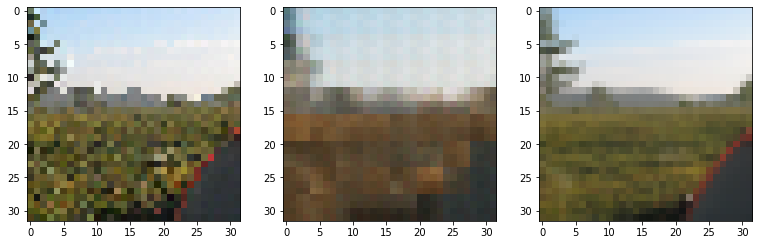

In [15]:
idx = 161
fig, ax = plt.subplots(1,3,figsize=(13,10))

with torch.no_grad():
    ax[0].imshow(val_in[idx].permute(1,2,0))
    ax[1].imshow(Net(val_in)[idx].permute(1,2,0))
    ax[2].imshow(val_tg[idx].permute(1,2,0))

In [16]:
mod = Model()
%time mod.train(train_in, train_tg, ne)

Completed: 20/20 CPU times: user 1min 25s, sys: 19.9 ms, total: 1min 25s
Wall time: 7.14 s


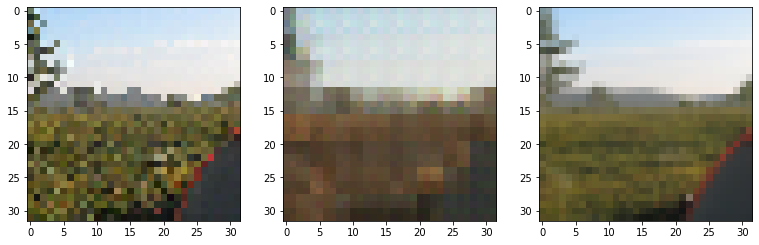

In [17]:
idx = 161
fig, ax = plt.subplots(1,3,figsize=(13,10))

with torch.no_grad():
    ax[0].imshow(val_in[idx].permute(1,2,0))
    ax[1].imshow(mod.predict(val_in)[idx].permute(1,2,0))
    ax[2].imshow(val_tg[idx].permute(1,2,0))

In [19]:
#mod.save('bestmodel.pth')

## State dict tests

In [2]:
mod = Model()

In [7]:
mod.net.state_dict['0.weights'][0,0]

tensor([[-0.1146,  0.0402],
        [-0.1088,  0.0040]])

In [11]:
mod.net._modules['0'].weight[0,0]

tensor([[-0.1146,  0.0402],
        [-0.1088,  0.0040]])

In [12]:
mod.net._modules['0'].weight *= 0

In [13]:
mod.net._modules['0'].weight[0,0]

tensor([[-0., 0.],
        [-0., 0.]])

In [14]:
mod.net.state_dict['0.weights'][0,0]

tensor([[-0., 0.],
        [-0., 0.]])

In [15]:
mod.save('testmodel.pth')

In [16]:
mod1 = Model()

In [17]:
mod1.net.state_dict['0.weights'][0,0]

tensor([[ 0.1958, -0.1610],
        [-0.0471,  0.3386]])

In [18]:
mod1.net._modules['0'].weight[0,0]

tensor([[ 0.1958, -0.1610],
        [-0.0471,  0.3386]])

In [19]:
mod1.load_pretrained_model('testmodel.pth')

In [20]:
mod1.net.state_dict['0.weights'][0,0]

tensor([[-0., 0.],
        [-0., 0.]])

In [21]:
mod1.net._modules['0'].weight[0,0]

tensor([[-0., 0.],
        [-0., 0.]])